In [1]:
from tqdm import tqdm as tqdm

Define a function that reads a multifasta file and retrns a dictionary with all the entries

In [2]:
def read_data(path): #reads a textfile with multiple genes in fasta format and returns a dictionary withentries genes and their sequences


    file = open(path)
    gene_dic = {}

    genes = file.read()

    genes = genes.split( '\n')

    for gene_name in range(0,len(genes) -1,2):
        gene_dic[genes[gene_name]] = genes[gene_name + 1]

    return(gene_dic)


Build a function to perform kmer hashing of a given sequence. The result is a list of kmers.

In [3]:
import time

In [4]:
def indexKmers(sequence, k):
    positions = {}
    for i in range(len(sequence) - k + 1):
        kmer = sequence[i:i + k]
        if kmer not in positions:
            positions[kmer] = []
        positions[kmer].append(i)
    return positions
# indexKmers(list(Q.values())[0], k = 4)
# start = time.time()
# indexKmers(list(Q.values())[0], k = 4)
# stop = time.time()
# print(stop - start)

In [5]:
Q = read_data('/home/tsomakiank/nikolaou_assignments/fasta_exercise/query.fa')
S = read_data('/home/tsomakiank/nikolaou_assignments/fasta_exercise/all_yeast_genes_minplus1k.fa')

In [6]:
threshold = 20
g = 3
k = 5

query_kmers = indexKmers(list(Q.values())[0], k)
max_score = 0


for seq_name, seq in tqdm(S.items()):
    sequence_kmers = indexKmers(seq,k)

    #Score each diagonal based on the number of the matching kmers
    diagonal_dic = {}
    for kmer, indices in sequence_kmers.items():
        if kmer in query_kmers:
            for index in indices:
                for j in query_kmers[kmer]:
                    diagonal_index = (index - j)
                    # increment the score for that diagonal
                    diagonal_dic[diagonal_index] = diagonal_dic.get(diagonal_index, 0) + 1


    #Filter out diagonal with score less than the threshold
    filtered_diagonal_dic = {diagonal : score for diagonal, score in diagonal_dic.items() if score >= threshold}



    #Sort the diagonal based on their index to make the merging more efficient
    sorted_diagonals = sorted(filtered_diagonal_dic.items())  # list of (diagonal_index, score)

    #Merge the diagonals based on the gap(g) parameter
    if sorted_diagonals:
        merged_diagonals = []
        current_diag, current_score = sorted_diagonals[0]

        for diag, score in sorted_diagonals[1:]:
            if diag - current_diag <= g:
                # If diagonal is close, merge
                current_score += score
            else:
                merged_diagonals.append((current_diag, current_score))
                current_diag, current_score = diag, score

        merged_diagonals.append((current_diag, current_score))  # append the last merged diagonal
        best_diagonal = max(merged_diagonals, key=lambda x: x[1])
        if best_diagonal[1] > max_score:
            max_score = best_diagonal[1]
            best_sequence = seq_name

print(best_sequence)

100%|██████████| 5765/5765 [00:21<00:00, 267.81it/s]

>YMR021C


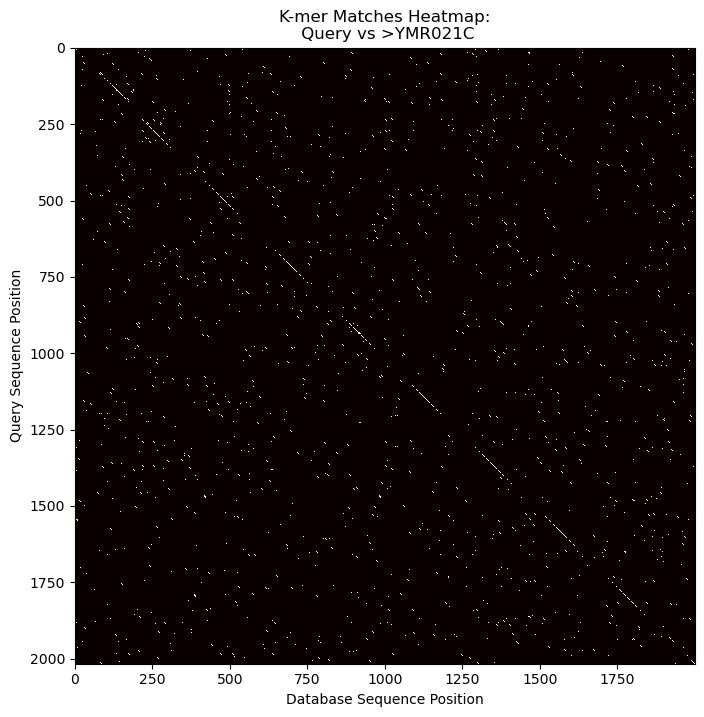

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose we have query and database sequences
query_seq = list(Q.values())[0]
db_seq = S[best_sequence]  # pick the best sequence, or any sequence you want to visualize

# Create a matrix of zeros
matrix = np.zeros((len(query_seq), len(db_seq)))

# Fill the matrix with 1s for kmer matches
k = 5
query_kmers = indexKmers(query_seq, k)
db_kmers = indexKmers(db_seq, k)

for kmer, q_indices in query_kmers.items():
    if kmer in db_kmers:
        for q_index in q_indices:
            for db_index in db_kmers[kmer]:
                # Fill the diagonal positions
                for offset in range(k):
                    if (q_index + offset < len(query_seq)) and (db_index + offset < len(db_seq)):
                        matrix[q_index + offset, db_index + offset] = 1

# Plot the matrix
plt.figure(figsize=(8, 8))
plt.imshow(matrix, cmap='hot', interpolation='nearest', origin='upper', aspect='auto')
plt.xlabel('Database Sequence Position')
plt.ylabel('Query Sequence Position')
plt.title(f'K-mer Matches Heatmap:\n Query vs {best_sequence}')
plt.show()
